In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from src.simple_models import SIRD
from src.stratified_models import stratified_SIRD
from src.load_data import load_italian_data

### Load data

In [3]:
# epidemiological data
data_casi, data_inf, data_rec, data_dec = load_italian_data()

# we only consider the 2nd wave
time = [220, 360]
data_casi = data_casi[time[0]:time[1]]
data_inf  = data_inf[time[0]:time[1]]
data_rec  = data_rec[time[0]:time[1]]
data_dec  = data_dec[time[0]:time[1]]

In [4]:
# demographic data
abitanti = np.array([4627514 + 6013709,
                     6794332 + 8795919,
                     9651541 + 7533486,
                     6019293 + 4554107])

abitanti_distro = abitanti/np.sum(abitanti)

In [5]:
# Covid related deaths data
decessi_totali = np.array([0, 1016, 15747, 101530])
decessi_distro = decessi_totali/np.sum(decessi_totali)

# fatality rates
fatality_rates = np.array([0.005, 0.05, 0.7, 5])

In [6]:
# vaccine data
vaccinati = np.array([1100417+2882429,
             3365508+5188996,
             6540360+5647205,
             5041860+4136087])

In [7]:
# optimal parameters
# The optimal parameters have been computed in the Notebook called "model_validation.ipynb"
X_opt = np.array([1.19577538e-01, 2.90130873e-02, 5.45212466e+01, 2.13034554e+00])

### Use the stratified SIR to compute predictions

In [8]:
def deaths_predictions(beta0, 
                       gamma, 
                       tau,
                       vaccinati, 
                       abitanti, 
                       efficacia_vacc, 
                       fatality_rates, 
                       inf0):

    frac_without_immunity = 1-efficacia_vacc*vaccinati/abitanti

    print('Fraction without immunity ', frac_without_immunity, '%')

    results = stratified_SIRD(beta0=beta0, 
                             gamma=gamma,
                             tau=tau,
                             fatality_rates_perc = frac_without_immunity*fatality_rates,
                             N = abitanti,
                             I0 = inf0*abitanti_distro, 
                             R0 = decessi_totali,
                             D0 = [0, 0, 0, 0])
  
    return results[4]

In [9]:
beta0 = round(X_opt[0], 2)
gamma = round(X_opt[1], 2)
tau = round(X_opt[2], 2)
f_scale = round(X_opt[3], 2)

deaths_pred_high = deaths_predictions(beta0=beta0, gamma=gamma, tau=tau,
                                 vaccinati= vaccinati, 
                                 abitanti = abitanti, 
                                 efficacia_vacc = 0.9, 
                                 fatality_rates = f_scale*fatality_rates,
                                 inf0=data_inf[0])

deaths_pred_low = deaths_predictions(beta0=beta0, gamma=gamma, tau=tau,
                                 vaccinati= vaccinati, 
                                 abitanti = abitanti, 
                                 efficacia_vacc = 1, 
                                 fatality_rates = f_scale*fatality_rates,
                                 inf0=data_inf[0])

time_grid = np.arange(0, len(deaths_pred_high[0]))

fasce_età = ['12-29 yo', '30-49 yo', '50-69 yo', '70+ yo']

Fraction without immunity  [0.66314385 0.50616231 0.36172294 0.21877993] %
Fraction without immunity  [0.62571539 0.45129145 0.29080327 0.1319777 ] %


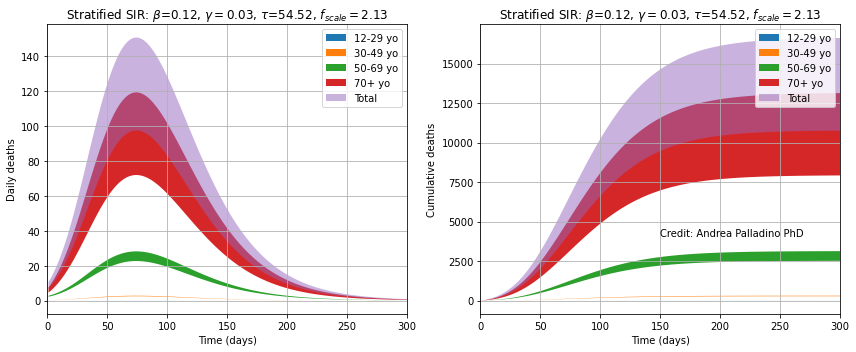

In [10]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(4):
    plt.fill_between(time_grid[1:], np.diff(deaths_pred_high[i]), np.diff(deaths_pred_low[i]), label=fasce_età[i])
plt.fill_between(time_grid[1:], np.diff(np.sum(deaths_pred_high, axis=0)), np.diff(np.sum(deaths_pred_low, axis=0)), label='Total', alpha=0.5)
plt.xlim(0, 300)
plt.xlabel('Time (days)')
plt.ylabel('Daily deaths')
plt.title('Stratified SIR: $\\beta$='+str(beta0)+', $\gamma=$'+str(gamma)+', $\\tau$='+str(tau)+', $f_{scale}=$'+str(f_scale))
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
for i in range(4):
    plt.fill_between(time_grid, deaths_pred_high[i], deaths_pred_low[i], label=fasce_età[i])
plt.fill_between(time_grid, np.sum(deaths_pred_high, axis=0), np.sum(deaths_pred_low, axis=0), label='Total', alpha=0.5)
plt.xlim(0, 300)
plt.legend()
plt.grid()
plt.xlabel('Time (days)')
plt.title('Stratified SIR: $\\beta$='+str(beta0)+', $\gamma=$'+str(gamma)+', $\\tau$='+str(tau)+', $f_{scale}=$'+str(f_scale))
plt.ylabel('Cumulative deaths')
plt.text(150, 4100, 'Credit: Andrea Palladino PhD')
plt.tight_layout()
plt.savefig('results/predictions_winter2122.png', dpi=300)
plt.show()